## Part 2. Model Training & Evaluation - RNN   
Now with the pretrained word embeddings acquired from Part 1 and the dataset acquired from
Part 0, you need to train a deep learning model for sentiment classification using the training set,
conforming to these requirements:


• Use the pretrained word embeddings from Part 1 as inputs; do not update them during training
(they are “frozen”).   

• Design a simple recurrent neural network (RNN), taking the input word embeddings, and
predicting a sentiment label for each sentence. To do that, you need to consider how to
aggregate the word representations to represent a sentence.   

• Use the validation set to gauge the performance of the model for each epoch during training.
You are required to use accuracy as the performance metric during validation and evaluation. 
   
• Use the mini-batch strategy during training. You may choose any preferred optimizer (e.g.,
SGD, Adagrad, Adam, RMSprop). Be careful when you choose your initial learning rate and
mini-batch size. (You should use the validation set to determine the optimal configuration.)
Train the model until the accuracy score on the validation set is not increasing for a few
epochs.
   
• Evaluate your trained model on the test dataset, observing the accuracy score.

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from datasets import load_dataset

In [2]:
from common_utils import load_glove_embeddings, set_seed
import nltk

In [3]:
# set seed 
set_seed()

In [4]:
# initialize parameters
BATCH_SIZE = 32
INPUT_SIZE = 100 # word embedding size 
HIDDEN_SIZE = 128 # just as a starter to see 
NUM_EPOCHS = 100 

In [5]:
EMBEDDING_DIM=100

In [6]:
# initialize word embeddings
word_embeddings = load_glove_embeddings()

Loading GloVe embeddings...


Repo card metadata block was not found. Setting CardData to empty.


Total GloVe words loaded: 400000


In [41]:
class vanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.num_layers = num_layers 
    self.hidden_size = hidden_size 
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
    self.fc = nn.Linear(hidden_size, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    output, h_t = self.rnn(x, h0) # we can just use the last hidden state output as the 
    last_hidden = h_t[-1]
    logits = self.sigmoid(self.fc(last_hidden))
    return logits 

In [7]:
# load dataset from huggingface first 
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [9]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

In [8]:
with open('result/word2idx.json', "r") as file:
    word2idx = json.load(file)

In [78]:
# create train, validate and test datasets and dataloaders 
from torch.utils.data import Dataset, DataLoader 

# TODO: change the num_tokens 
class EmbeddingsDataset(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=12, word_embeddings=word_embeddings):
    self.num_tokens_per_sentence = 8
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)
    
  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_embedding_tensor(tokens)
    label = torch.tensor(self.y[index], dtype=torch.float)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x)
    return tokens 

  def convert_sentence_into_embedding_tensor(self, tokens):
    sentence_embeddings = [] 
    num_tokens_used = 0
    for i, token in enumerate(tokens): 
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 

      if token in self.word_embeddings: # only use words that are in the word_embeddings matrix, otherwise skip
        embedding_tensor = torch.tensor(self.word_embeddings[token], dtype=torch.float)
        sentence_embeddings.append(embedding_tensor)
      num_tokens_used += 1 

    # if not enough tokens in the sentence, pad with zero tensors 
    if len(sentence_embeddings) < self.num_tokens_per_sentence:
            # Padding with zero vectors if less than 8 embeddings
            padding = [torch.zeros(EMBEDDING_DIM) for _ in range(self.num_tokens_per_sentence - len(sentence_embeddings))]
            sentence_embeddings.extend(padding)

    sentence_tensor = torch.stack(sentence_embeddings)
    return sentence_tensor 
  



In [79]:
train_dataset_ed = EmbeddingsDataset(train_dataset['text'], train_dataset['label'])
validation_dataset_ed = EmbeddingsDataset(validation_dataset['text'], validation_dataset['label'])
test_dataset_ed = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])



# implement minibatch training 
train_dataloader = DataLoader(train_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

# prepare validation and test dataloaders 
validation_dataloader = DataLoader(validation_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset_ed, batch_size=BATCH_SIZE, shuffle=True)

In [72]:
# word_embeddings['the'].shape # get the size of the embeddings, so that we can use this as input_size

In [67]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch = torch.tensor(X_batch, dtype=torch.float)
        y_batch = torch.tensor(y_batch, dtype=torch.float)
        # Forward pass
        pred = model(X_batch)
        pred = pred.squeeze(1)
        y_val = y_batch
        loss = loss_fn(pred, y_val)
        train_loss += loss.item() 
        train_correct += ((pred >= 0.5).float()==y_batch).sum().item() 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop(validate_dataloader, model, loss_fn):
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            X_batch = torch.tensor(X_batch, dtype=torch.float)
            y_batch = torch.tensor(y_batch, dtype=torch.float)

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).float()
            test_loss += loss_fn(pred, y_batch).item()
            test_correct += (pred_binary == y_batch).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [10]:
# initialize the model
RNN_model = vanillaRNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers=4, num_classes=1) 
  # num_classes==1 because binary classification
  # TODO: can try to increase num_layers > 1, that might perform better 
# initialize training params 
optim = torch.optim.Adam(RNN_model.parameters(), lr=0.001)

NameError: name 'vanillaRNN' is not defined

In [11]:
criterion = nn.BCELoss()


# Testing the model, just using epoch = 100 

In [110]:
validation_acc = [] 
train_acc = []
for i in range(NUM_EPOCHS):
  train_loss, train_correct = train_loop(train_dataloader, RNN_model, criterion, optim) 
  validate_loss, validate_correct = test_loop(validation_dataloader, RNN_model, criterion)
  validation_acc.append(validate_correct)
  train_acc.append(train_correct)
  if i%10 == 0:
    print(f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}")
  



/var/folders/sx/8nz4dts119bfc1svlcbykndr0000gn/T/ipykernel_2892/987989442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float)
/var/folders/sx/8nz4dts119bfc1svlcbykndr0000gn/T/ipykernel_2892/987989442.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
/var/folders/sx/8nz4dts119bfc1svlcbykndr0000gn/T/ipykernel_2892/987989442.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch, dtype=torch.float)
/var/folders

Epoch:1 	Validation Acc:0.6294559099437148 	Train Acc:0.6021101992966003
Epoch:11 	Validation Acc:0.6857410881801126 	Train Acc:0.7083235638921453
Epoch:21 	Validation Acc:0.6791744840525328 	Train Acc:0.8248534583821805
Epoch:31 	Validation Acc:0.6575984990619137 	Train Acc:0.9331770222743259


KeyboardInterrupt: 

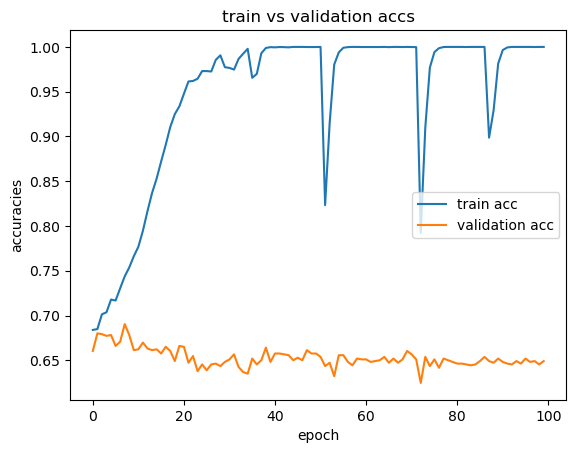

In [108]:
import matplotlib.pyplot as plt 

plt.plot(train_acc, label="train acc")
plt.plot(validation_acc, label="validation acc")

plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.title("train vs validation accs")
plt.legend()
plt.show()

# Hyperparameter Tuning
We will perform grid search on the no. of training epochs, lr, optimizer and batch sizes



Question 2. RNN
(a) Report the final configuration of your best model, namely the number of training epochs,
learning rate, optimizer, batch size.
  - Implement Bayesian search
(b) Report the accuracy score on the test set, as well as the accuracy score on the validation
set for each epoch during training.
(c) RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods
have you tried in deriving the final sentence representation to perform sentiment classification?
Describe all the strategies you have implemented, together with their accuracy scores on the
test set

In [88]:
# use "the" as pad 
word2idx["<pad>"]

KeyError: '<pad>'

In [93]:
embeddings = [word_embeddings[word] for word in word_embeddings.keys()]


In [94]:
embedding_matrix_np = np.array(embeddings)
embedding_matrix_np = np.vstack((np.zeros((1, 100)), embedding_matrix_np))


In [95]:
embedding_matrix_np.shape

(400001, 100)

In [96]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(train_dataloader)
    size = len(train_dataloader.dataset)
    train_loss, train_correct = 0, 0
    for batch_no, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch = torch.tensor(X_batch)
        y_batch = torch.tensor(y_batch, dtype=torch.float)
        # Forward pass
        pred = model(X_batch)
        pred = pred.squeeze(1)
        y_val = y_batch
        loss = loss_fn(pred, y_val)
        train_loss += loss.item() 
        train_correct += ((pred >= 0.5).float()==y_batch).sum().item() 
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches 
    train_correct /= size 

    return train_loss, train_correct 
   

def test_loop(validate_dataloader, model, loss_fn):
    model.eval()
    num_batches = len(validate_dataloader)
    size = len(validate_dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in validate_dataloader:
            X_batch = torch.tensor(X_batch)
            y_batch = torch.tensor(y_batch, dtype=torch.float)

            pred = model(X_batch)
            pred = pred.squeeze(1)
            pred_binary = (pred >= 0.5).float()
            test_loss += loss_fn(pred, y_batch).item()
            test_correct += (pred_binary == y_batch).sum().item()

    test_loss /= num_batches
    test_correct /= size
    return test_loss, test_correct

In [97]:
# using nn.Embeddings 
import torch
import torch.nn as nn



class VanillaRNNWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, embedding_matrix_torch=torch.tensor(embedding_matrix_np, dtype=torch.float)):
        super(VanillaRNNWithEmbedding, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix_torch, freeze=True, padding_idx=0)
        self.num_layers = num_layers 
        self.hidden_size = hidden_size 
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # this is the num rows of the input matrix 
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

 
    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, dtype=torch.float)
        # Pass the embeddings through the RNN layer
        out, _ = self.rnn(x, h0)
        # Only take the last output for each sequence
        out = out[:, -1, :]
        # Pass through the fully connected layer
        out = self.fc(out)
        # Apply sigmoid activation (for binary classification)
        out = self.sigmoid(out)
        
        return out

In [98]:
from torch.utils.data import Dataset, DataLoader 

# TODO: change the num_tokens 
class EmbeddingsDataset2(Dataset):
  def __init__(self, X, y, num_tokens_per_sentence=8, word_embeddings=word_embeddings):
    self.num_tokens_per_sentence = num_tokens_per_sentence
    self.word_embeddings = word_embeddings
    self.X = X # train_dataset['text']
    self.y = y # train_dataset['label']
    self.len = len(self.X)

  def __getitem__(self, index):
    # tokenize the sentence 
    tokens = self.tokenize_sentence(self.X[index])
    # convert each token to embeddings 
    sentence_tensor = self.convert_sentence_into_indices(tokens)
    label = torch.tensor(self.y[index], dtype=torch.float)
    return sentence_tensor, label 

  def __len__(self):
    return self.len 

  def tokenize_sentence(self, x): 
    '''
    returns a list containing the embeddings of each token 
    '''
    tokens = nltk.word_tokenize(x)
    return tokens 
  
  def convert_sentence_into_indices(self, tokens):
    indices = []
    num_tokens_used = 0 
    for token in tokens:
      if num_tokens_used == self.num_tokens_per_sentence:
        break # we have enough of tokens from the sentence 
      if token in word2idx:
        indices.append(word2idx[token])
        num_tokens_used += 1 
    # # if not enough tokens in the sentence, use index of ?? 
    if len(indices) < self.num_tokens_per_sentence:
      padding = [0 for _ in range(self.num_tokens_per_sentence - len(indices))]
      indices.extend(padding)

    indices = torch.tensor(indices, dtype=torch.long)
    return indices
  # def convert_sentence_into_embedding_tensor(self, tokens):
  #   sentence_embeddings = [] 
  #   num_tokens_used = 0
  #   for i, token in enumerate(tokens): 
  #     if num_tokens_used == self.num_tokens_per_sentence:
  #       break # we have enough of tokens from the sentence 

  #     if token in self.word_embeddings: # only use words that are in the word_embeddings matrix, otherwise skip
  #       embedding_tensor = torch.tensor(self.word_embeddings[token], dtype=torch.float)
  #       sentence_embeddings.append(embedding_tensor)

  #   # if not enough tokens in the sentence, pad with zero tensors 
  #   if len(sentence_embeddings) < self.num_tokens_per_sentence:
  #           # Padding with zero vectors if less than 8 embeddings
  #           padding = [torch.zeros(EMBEDDING_DIM) for _ in range(self.num_tokens_per_sentence - len(sentence_embeddings))]
  #           sentence_embeddings.extend(padding)

  #   sentence_tensor = torch.stack(sentence_embeddings)
  #   return sentence_tensor 
  

In [ ]:
RNN_embeddings_model = VanillaRNNWithEmbedding(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=4, num_classes=1)
optim = torch.optim.Adam(RNN_embeddings_model.parameters(), lr=0.001)


train_dataset_ed2 = EmbeddingsDataset2(train_dataset['text'], train_dataset['label'])
validation_dataset_ed2 = EmbeddingsDataset2(validation_dataset['text'], validation_dataset['label'])
# test_dataset_ed2 = EmbeddingsDataset(test_dataset['text'], test_dataset['label'])


train_dataloader2 = DataLoader(train_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader2 = DataLoader(validation_dataset_ed2, batch_size=BATCH_SIZE, shuffle=True)
validation_acc = [] 
train_acc = []
for i in range(NUM_EPOCHS):
  train_loss, train_correct = train_loop(train_dataloader2, RNN_embeddings_model, criterion, optim) 
  validate_loss, validate_correct = test_loop(validation_dataloader2, RNN_embeddings_model, criterion)
  validation_acc.append(validate_correct)
  train_acc.append(train_correct)
  if i%10 == 0:
    print(f"Epoch:{i+1} \tValidation Acc:{validate_correct} \tTrain Acc:{train_correct}")
  


C:\Users\USER\AppData\Local\Temp\ipykernel_97572\4224571544.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_97572\4224571544.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_batch = torch.tensor(y_batch, dtype=torch.float)
C:\Users\USER\AppData\Local\Temp\ipykernel_97572\4224571544.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_batch = torch.tensor(X_batch)
C:\Users\USER\AppData\Local\Temp\ipykernel_97572\4224571544.py:36: UserWarning: To copy cons

Epoch:1 	Validation Acc:0.5318949343339587 	Train Acc:0.5164126611957796


In [66]:
train_acc

[]